In [104]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# importing the initial model I am going to use
# will be adding more models later on in the notebook!
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
# need statistical analysis tools
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
# importing some evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import cross_val_score
# adding in some regularization tools
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV
# feature selection tools
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
# pipelines -- ambitious goal
from sklearn.pipeline import Pipeline

In [36]:
# Importing the car price data
data = pd.read_csv('car_price_data.csv')
print(data.shape)
data.head()

(205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Some of these variables will need to be encoded. I am going to use `pd.get_dummies` for that.

In [3]:
data['CarName'].value_counts()

toyota corona          6
toyota corolla         6
peugeot 504            6
subaru dl              4
honda civic            3
                      ..
jaguar xf              1
dodge challenger se    1
porsche macan          1
audi 5000s (diesel)    1
honda accord cvcc      1
Name: CarName, Length: 147, dtype: int64

I am noticing that the car's MAKE always comes before the first space in the `CarName` variable. I can possibly use a Regex function to capture just the car's MAKE.

In [4]:
# Importing Regex
import re

In [37]:
make_list = data['CarName'].to_list()

In [5]:
make_list[0:5]

['alfa-romero giulia',
 'alfa-romero stelvio',
 'alfa-romero Quadrifoglio',
 'audi 100 ls',
 'audi 100ls']

Regex was actually not necessary. I used the `.partition()` method.

In [38]:
companies = []
for name in make_list:
    companies.append(name.partition(' ')[0])
print(companies[0:10])

['alfa-romero', 'alfa-romero', 'alfa-romero', 'audi', 'audi', 'audi', 'audi', 'audi', 'audi', 'audi']


In [7]:
companies_set = set(companies)
len(companies_set)

28

In [8]:
companies_set

{'Nissan',
 'alfa-romero',
 'audi',
 'bmw',
 'buick',
 'chevrolet',
 'dodge',
 'honda',
 'isuzu',
 'jaguar',
 'maxda',
 'mazda',
 'mercury',
 'mitsubishi',
 'nissan',
 'peugeot',
 'plymouth',
 'porcshce',
 'porsche',
 'renault',
 'saab',
 'subaru',
 'toyota',
 'toyouta',
 'vokswagen',
 'volkswagen',
 'volvo',
 'vw'}

There are some issues with the make names and also some duplicates. Will need to use a conditional statement to fix the ones that are spelt wrong or duplicated.  
  
Since there aren't too many I can just do this by hand. But I will still write a function so I can correct any of the entries in my data with incorrect MAKE names.

In [39]:
# First I am going to lowercase all of the CarNames in the original data
companies_lower = [x.lower() for x in companies]

In [40]:
data.insert(2,'make',companies)

In [41]:
data.head()

,car_ID,symboling,make,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [42]:
data.drop(columns=['CarName'], axis=1, inplace=True)

In [43]:
# Replacing those with easily fixed names. Volkswagen is another issue.
data.replace({'maxda': 'mazda', 'porcshce': 'porsche', 'toyouta':'toyota'}, inplace=True)


In [44]:
data.replace({'vw':'volkswagen', 'vokswagen':'volkswagen'}, inplace=True)


In [16]:
data.make.value_counts()

toyota         32
nissan         17
mazda          17
mitsubishi     13
honda          13
subaru         12
volkswagen     12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
renault         2
mercury         1
Nissan          1
Name: make, dtype: int64

In [45]:
# Nissan slipped through somehow
data.replace('Nissan', 'nissan', inplace=True)

In [18]:
data.make.value_counts()

toyota         32
nissan         18
mazda          17
mitsubishi     13
honda          13
subaru         12
volkswagen     12
peugeot        11
volvo          11
dodge           9
buick           8
bmw             8
plymouth        7
audi            7
saab            6
porsche         5
isuzu           4
chevrolet       3
alfa-romero     3
jaguar          3
renault         2
mercury         1
Name: make, dtype: int64

Now our data has only make and we can start comparing companies as part of our EDA

In [19]:
data.head()

,car_ID,symboling,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


Thinking... can also do some sort of clustering techniques here. Cluster the cars into categories based on whatever the computer finds.  
  
Time to start formatting the data for linear regression techniques.

In [46]:
data.drop(columns=['car_ID'], axis=1, inplace=True)

In [47]:
data.symboling.value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

Now to visualize data distributions.

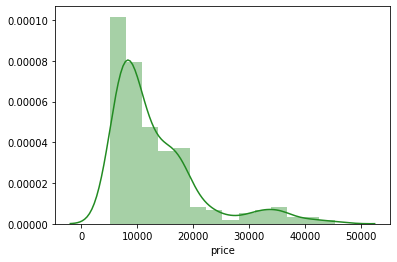

In [48]:
sns.distplot(data['price'], color='forestgreen')

In [49]:
pd.DataFrame(data.groupby('make')['price'].value_counts()).T

make  alfa-romero                audi                                          \
price   16500.000 13495.000 13950.000 15250.000 17450.000 17710.000 17859.167   
price           2         1         1         1         1         1         1   

make                            bmw                                          \
price 18920.000 23875.000 16430.000 16925.000 20970.000 21105.000 24565.000   
price         1         1         1         1         1         1         1   

make                                    buick                                \
price 30760.000 36880.000 41315.000 25552.000 28176.000 28248.000 31600.000   
price         1         1         1         1         1         1         1   

make                                          chevrolet                      \
price 34184.000 35056.000 40960.000 45400.000 5151.000  6295.000  6575.000    
price         1         1         1         1         1         1         1   

make      dodge                                                              \
price 5572.000  6229.000  6377.000  6692.000  7609.000  7957.000  8558.000    
price         1         1         1         1         1         1         1   

make                          honda                                          \
price 8921.000  12964.000 7295.000  5399.000  6479.000  6529.000  6855.000    
price         1         1         2         1         1         1         1   

make                                                                         \
price 7129.000  7895.000  8845.000  9095.000  10295.000 10345.000 12945.000   
price         1         1         1         1         1         1         1   

make      isuzu                        jaguar                         mazda  \
price 8916.500  6785.000  11048.000 32250.000 35550.000 36000.000 5195.000    
price         2         1         1         1         1         1         1   

make                                                                         \
price 6095.000  6695.000  6795.000  7395.000  8495.000  8845.000  10245.000   
price         1         1         1         1         1         1         1   

make                                                                         \
price 10595.000 10795.000 10945.000 11245.000 11845.000 13645.000 15645.000   
price         1         1         1         1         1         1         1   

make                        mercury mitsubishi                                \
price 18280.000 18344.000 16503.000  9279.000  5389.000  6189.000  6669.000    
price         1         1         1          2         1         1         1   

make                                                                         \
price 6989.000  7689.000  8189.000  8499.000  9959.000  12629.000 14489.000   
price         1         1         1         1         1         1         1   

make               nissan                                                    \
price 14869.000 13499.000 5499.000  6649.000  6849.000  7099.000  7299.000    
price         1         2         1         1         1         1         1   

make                                                                         \
price 7349.000  7499.000  7799.000  7999.000  8249.000  8949.000  9549.000    
price         1         1         1         1         1         1         1   

make                                            peugeot                      \
price 14399.000 17199.000 18399.000 19699.000 11900.000 12440.000 13200.000   
price         1         1         1         1         1         1         1   

make                                                                         \
price 13860.000 15580.000 16630.000 16695.000 16900.000 17075.000 17950.000   
price         1         1         1         1         1         1         1   

make             plymouth                                                    \
price 18150.000 5572.000  6229.000  6692.000  7609.000  7957.000  8921.000    
price         1         1

In [ ]:
# sns.pairplot(data)

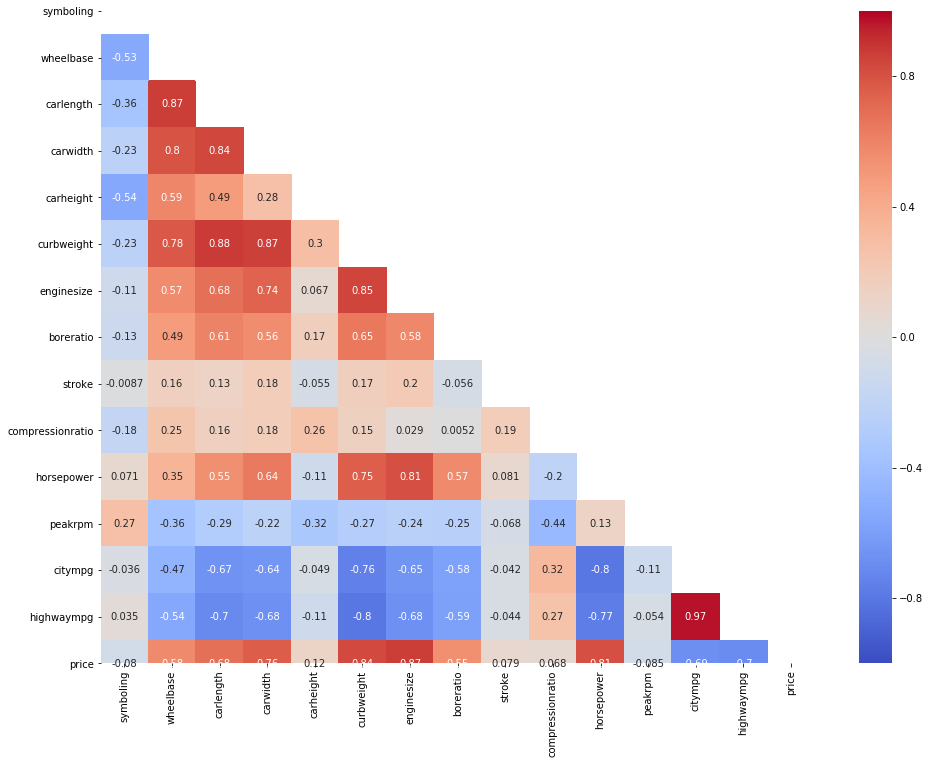

In [25]:
# Looking for multicollinearity
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

In [20]:
data.drop(columns=['symboling'], axis=1, inplace=True)

There are a lot of related features here. I want to reduce this, so I might start to engineer features that are combinations of these features.

In [27]:
data.head()

,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [28]:
data.enginelocation.value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

In [51]:
# Going to start cleaning up the data
make_d = pd.get_dummies(data['make'], prefix='make', drop_first=True)
body = pd.get_dummies(data['carbody'], prefix='body', drop_first=True)
cyl = pd.get_dummies(data['cylindernumber'], prefix='cyl', drop_first=True)
fs = pd.get_dummies(data['fuelsystem'], prefix='fs', drop_first=True)
et = pd.get_dummies(data['enginetype'], prefix='et', drop_first=True)
data['fueltype'] = data.fueltype.map({'gas':0, 'diesel':1})
data['aspiration'] = data.aspiration.map({'std':0, 'turbo':1})
data['doornumber'] = data.doornumber.map({'four':0, 'two':1})
dt = pd.get_dummies(data['drivewheel'], prefix='dt', drop_first=True)
data['enginelocation'] = data.enginelocation.map({'front':0, 'rear':1})

In [22]:
# Let's review these changes
print(data.shape)
data.head()

(205, 24)


,make,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero,0,0,1,convertible,rwd,0,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero,0,0,1,convertible,rwd,0,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero,0,0,1,hatchback,rwd,0,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi,0,0,0,sedan,fwd,0,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi,0,0,0,sedan,4wd,0,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [52]:
# Now need to remove the columns I dummied and insert them into the data frame
data.drop(columns=['make', 'carbody', 'cylindernumber', 'fuelsystem', 'enginetype',
                  'drivewheel'], axis=1, inplace=True)
# And re-insert the dummied variables
data = pd.concat([data, make_d, body, cyl, fs, et, dt], axis=1)

In [24]:
print(data.shape)
data.head()

(205, 64)


,fueltype,aspiration,doornumber,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,make_audi,make_bmw,make_buick,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercury,make_mitsubishi,make_nissan,make_peugeot,make_plymouth,make_porsche,make_renault,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,body_hardtop,body_hatchback,body_sedan,body_wagon,cyl_five,cyl_four,cyl_six,cyl_three,cyl_twelve,cyl_two,fs_2bbl,fs_4bbl,fs_idi,fs_mfi,fs_mpfi,fs_spdi,fs_spfi,et_dohcv,et_l,et_ohc,et_ohcf,et_ohcv,et_rotor,dt_fwd,dt_rwd
0,0,0,1,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,0,0,0,0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


Has increased the dimensionality by 40. Not bad. Will be dropping columns along the way after using Feature Selection tools. 


In [53]:
# After reviewing the heat matrix, there is some multicollinearity I need to deal with
# Going to drop a couple columns and re-run the heat matrix
copy = data.copy()
copy.drop(columns=['carlength', 'carwidth'], axis=1, inplace=True)


In [109]:
def heat_matrix(data):
    f, ax = plt.subplots(figsize=(16, 12))
    matrix = np.triu(data.corr())
    sns.heatmap(data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

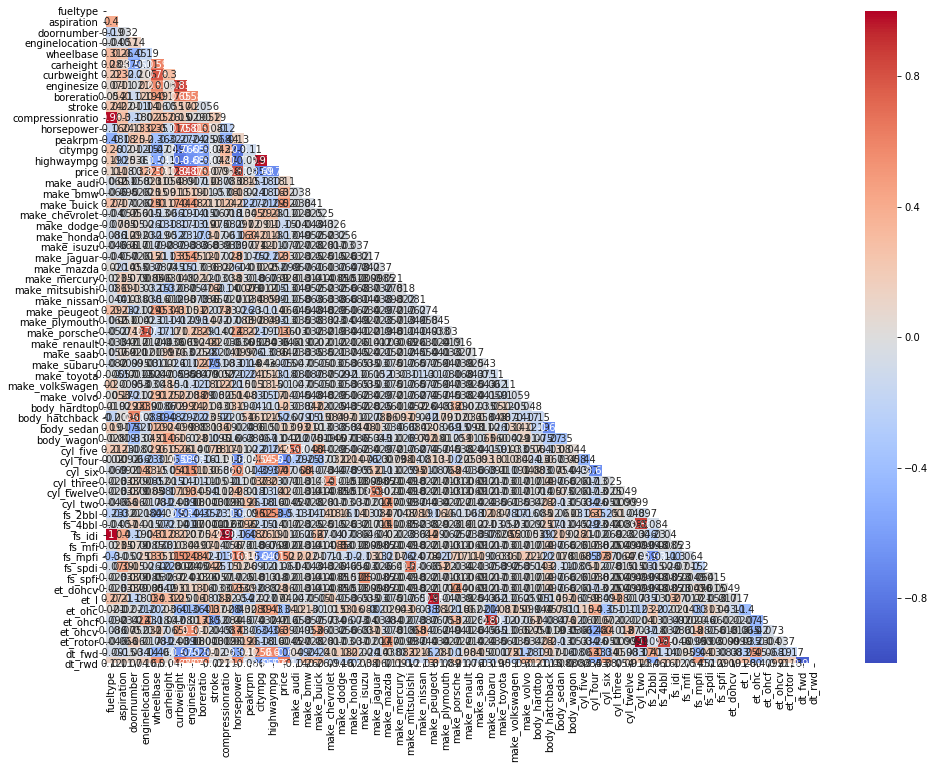

In [35]:
heat_matrix(copy)

That isn't very telling. There are still some hot spots left, I need to reduce dimensionality. I am going to run some baseline models with the data and see what I can do from there.

In [93]:
lr = LinearRegression()
X = copy.drop(columns=['price'], axis=1)
y = copy.price
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3)
print('Training Set Dimensions', X_train.shape, y_train.shape)
print('Test Set Dimensions', X_test.shape, y_test.shape)

Training Set Dimensions (143, 62) (143,)
Test Set Dimensions (62, 62) (62,)


In [56]:
# Fitting model
lr.fit(X_train,y_train)
# Getting the R^2 score
print('R^2 Score of Baseline Model: ', lr.score(X_train,y_train))


R^2 Score of Baseline Model:  0.9758430844399862


Looks like we have some severe overfitting. Let's look at the test data.

RMSE : 2660.92077756699


Text(0, 0.5, 'Predictions')

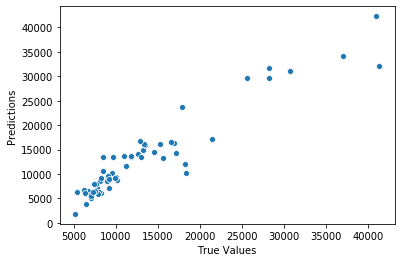

In [57]:
# Making a prediction using the test data
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE :', rmse)
sns.scatterplot(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [58]:
# R^2 of the test data
lr.score(X_test,y_test)

0.8978052552911945

In [59]:
# Using OLS to create a model and return some metrics
outcome = 'price'
predictors = copy.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=copy).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     64.95
Date:                Mon, 15 Jun 2020   Prob (F-statistic):           1.34e-80
Time:                        13:20:56   Log-Likelihood:                -1795.4
No. Observations:                 205   AIC:                             3709.
Df Residuals:                     146   BIC:                             3905.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1.062e+04   1.11e+04     -0.955      0.341   -3.26e+04    1.13e+04
symboling         -102.5669    260.381     -0.394      0.694    -617.169     412.035
fueltype          5122.1894   3434.951      1.491      0.138   -1666.460    1.19e+04
aspiration        2209.7994    849.543      2.601      0.010     530.809    3888.790
doornumber        -227.5098    501.547     -0.454      0.651   -1218.739     763.720
enginelocation    5429.5978   1901.943      2.855      0.005    1670.702    9188.494
wheelbase          227.6071     77.122      2.951      0.004      75.187     380.027
carheight         -288.7733    136.647     -2.113      0.036    -558.835     -18.711
curbweight           5.3473      1.495      3.576      0.000       2.392       8.303
enginesize          90.3065     26.404      3.420      0.001      38.123     142.490
boreratio        -3137.5100   1908.945     -1.644      0.102   -6910.245     635.225
stroke           -1282.0449   1029.846     -1.245      0.215   -3317.377     753.288
compressionratio  -682.8075    506.258     -1.349      0.180   -1683.347     317.733
horsepower           9.8819     24.660      0.401      0.689     -38.854      58.618
peakrpm              2.3925      0.673      3.556      0.001       1.063       3.722
citympg             47.4529    138.624      0.342      0.733    -226.517     321.423
highwaympg         115.5875    119.216      0.970      0.334    -120.025     351.200
make_audi         1139.6301   2392.656      0.476      0.635   -3589.085    5868.345
make_bmw          5213.7722   2418.880      2.155      0.033     433.229    9994.315
make_buick        3604.4145   2546.105      1.416      0.159   -1427.569    8636.398
make_chevrolet   -4846.6081   2274.435     -2.131      0.035   -9341.678    -351.538
make_dodge       -5066.1853   1846.370     -2.744      0.007   -8715.251   -1417.119
make_honda       -2079.1980   2240.092     -0.928      0.355   -6506.395    2347.999
make_isuzu       -3255.3814   2046.342     -1.591      0.114   -7299.660     788.897
make_jaguar         74.7555   2710.259      0.028      0.978   -5281.653    5431.164
make_mazda       -1979.9471   1755.283     -1.128      0.261   -5448.993    1489.099
make_mercury     -2820.4921   3036.083     -0.929      0.354   -8820.842    3179.857
make_mitsubishi  -5574.1354   1891.416     -2.947      0.004   -9312.226   -1836.044
make_nissan      -3181.0308   1739.464     -1.829      0.069   -6618.812     256.751
make_peugeot     -3004.5555   1844.767     -1.629      0.106   -6650.453     641.342
make_plymouth    -5395.3818   1861.925     -2.898      0.004   -9075.190   -1715.574
make_porsche      5646.5550   2951.692      1.913      0.058    -187.009    1.15e+04
make_renault     -3399.5211   2308.252     -1.473      0.143   -7961.426    1162.383
make_saab          408.

In [91]:
# From this analysis I have chosen all variables with p-value < 0.05
variables = ['aspiration', 'enginelocation', 'wheelbase', 'carheight', 'curbweight',
            'enginesize', 'peakrpm', 'make_bmw', 'make_chevrolet', 'make_dodge',
            'make_mitsubishi', 'make_plymouth', 'make_subaru', 'make_toyota',
            'body_hardtop', 'body_hatchback', 'body_sedan', 'body_wagon', 'et_ohcf']
X_anova = copy[variables]
y_anova = copy.price

In [84]:
# Defining function to plot linear regression models against the test data
# Will also print out the important metrics
def linreg(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.3)
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    print('New R^2 value for training data is: ', lr.score(X_train,y_train))
    y_pred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print('Test RMSE: ',rmse)
    fig,ax=plt.subplots(figsize=(12,8))
    sns.lineplot(x=y_test.reset_index(drop=True).index,y=y_test,color='blue',ax=ax,)
    sns.lineplot(x=y_test.reset_index(drop=True).index,y=y_pred,color='grey',ax=ax)
    plt.xlabel('INDEX')
    plt.ylabel('PRICE')
    plt.title('COMPARISON OF MODEL TO ACTUAL DATA')
    plt.legend(['TEST DATA','PREDICTION'],loc='best')
    plt.show()

New R^2 value for training data is:  0.9133053844100566
Test RMSE:  3152.6847475252794


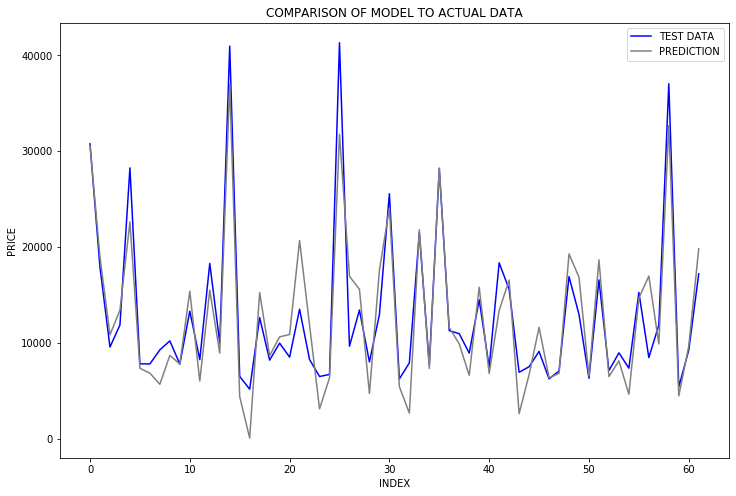

In [92]:
linreg(X_anova,y_anova)

In [94]:
# Using RFE for recursive feature selection
from sklearn.feature_selection import RFE
selector = RFE(lr, n_features_to_select=5)
selector = selector.fit(X, y)

In [95]:
# Making this into a data frame to see which features I should keep
features = pd.DataFrame(selector.ranking_)
features['variables'] = X.columns
features.rename(columns={0:'rank'}, inplace=True)
features.sort_values(by='rank')

,rank,variables
23,1,make_jaguar
4,1,enginelocation
18,1,make_buick
17,1,make_bmw
9,1,boreratio
...,...,...
35,54,make_volkswagen
15,55,highwaympg
14,56,citympg
7,57,curbweight


In [96]:
feats = features[features['rank'] < 15].sort_values(by='rank')['variables'].to_list()

Without standardizing any of this data, I am going to run another model using the top features from above.

New R^2 value for training data is:  0.8940113969302573
Test RMSE:  3516.5588766258297


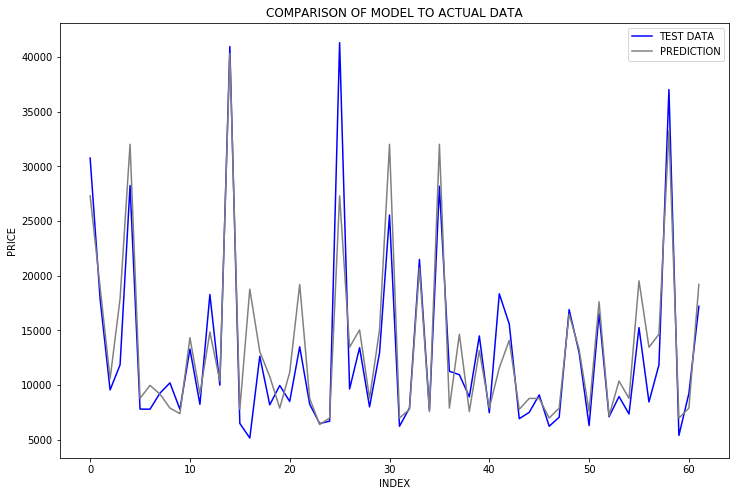

In [97]:
X_rfe = copy[feats]
y_rfe = copy.price
linreg(X_rfe,y_rfe)

In [98]:
# Do I need to standardize anything in my anova data? RFE data?
X_anova.head()

,aspiration,enginelocation,wheelbase,carheight,curbweight,enginesize,peakrpm,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf
0,0,0,88.6,48.8,2548,130,5000,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,88.6,48.8,2548,130,5000,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,94.5,52.4,2823,152,5000,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,99.8,54.3,2337,109,5500,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,99.4,54.3,2824,136,5500,0,0,0,0,0,0,0,0,0,1,0,0


In [99]:
X_rfe.head()

,enginelocation,boreratio,make_bmw,make_buick,make_jaguar,cyl_three,cyl_four,et_rotor,cyl_six,cyl_five,make_audi,make_subaru,cyl_two,make_saab,make_porsche,make_peugeot,et_l,et_dohcv
0,0,3.47,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,3.47,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,2.68,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,3.19,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,3.19,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [100]:
# The RFE data seems to be mostly the categorical variables, whereas the ANOVA data isn't
# Will try out scaler on the ANOVA data
scaler = StandardScaler()
X_anova_sc = scaler.fit_transform(X_anova)
X_anova_sc = pd.DataFrame(X_anova_sc, columns=X_anova.columns)
X_anova_sc.head()

,aspiration,enginelocation,wheelbase,carheight,curbweight,enginesize,peakrpm,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf
0,-0.469295,-0.121867,-1.690772,-2.020417,-0.014566,0.074449,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,-0.938474,-0.372678,-0.280976
1,-0.469295,-0.121867,-1.690772,-2.020417,-0.014566,0.074449,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,-0.938474,-0.372678,-0.280976
2,-0.469295,-0.121867,-0.708596,-0.543527,0.514882,0.604046,-0.262960,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,1.388730,-0.938474,-0.372678,-0.280976
3,-0.469295,-0.121867,0.173698,0.235942,-0.420797,-0.431076,0.787855,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,1.065559,-0.372678,-0.280976
4,-0.469295,-0.121867,0.107110,0.235942,0.516807,0.218885,0.787855,-0.201517,-0.121867,-0.214286,-0.260208,-0.188025,-0.249351,-0.430083,-0.201517,-0.720082,1.065559,-0.372678,-0.280976


New R^2 value for training data is:  0.9133053844100566
Test RMSE:  3152.684747525305


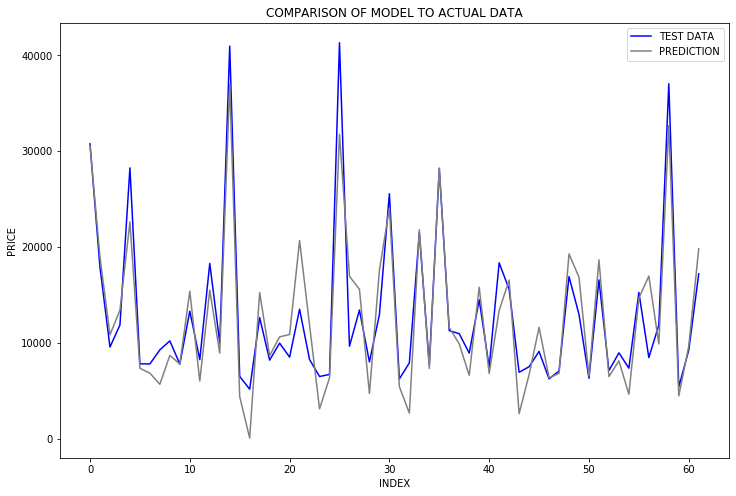

In [101]:
# Let's re-run the linear regression on this transformed data
linreg(X_anova_sc, y_anova)

No change there.

In [119]:
# Going to make a different scaled data frame for the ANOVA
# Only will scale the continuous features with MinMaxScaler
mm = MinMaxScaler()
cont_anova_data = X_anova[['wheelbase','carheight','curbweight','enginesize','peakrpm']]
cont_anova_data = mm.fit_transform(cont_anova_data)
cont_anova_data = pd.DataFrame(cont_anova_data,columns=['wheelbase_mm','carheight_mm','curbweight_mm',
                                                       'enginesize_mm','peakrpm_mm'])
X_anova_sc2 = X_anova.copy()
X_anova_sc2.drop(columns=['wheelbase', 'carheight', 'curbweight',
                         'enginesize', 'peakrpm'], axis=1, inplace=True)
X_anova_sc2 = pd.concat([X_anova_sc2, cont_anova_data], axis=1)
X_anova_sc2.head()

,aspiration,enginelocation,make_bmw,make_chevrolet,make_dodge,make_mitsubishi,make_plymouth,make_subaru,make_toyota,body_hardtop,body_hatchback,body_sedan,body_wagon,et_ohcf,wheelbase_mm,carheight_mm,curbweight_mm,enginesize_mm,peakrpm_mm
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.411171,0.260377,0.346939
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.058309,0.083333,0.411171,0.260377,0.346939
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.230321,0.383333,0.517843,0.343396,0.346939
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.384840,0.541667,0.329325,0.181132,0.551020
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.373178,0.541667,0.518231,0.283019,0.551020


New R^2 value for training data is:  0.9132626230262311
Test RMSE:  3146.2735874526684


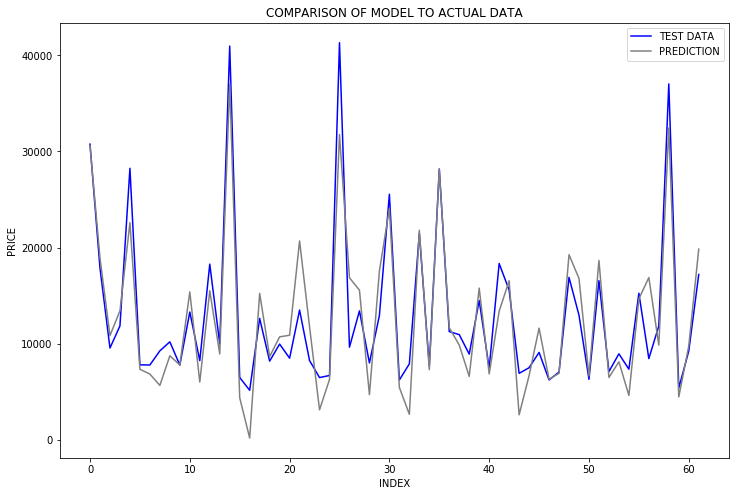

In [107]:
linreg(X_anova_sc2, y_anova)

That helped my RMSE. Nice!

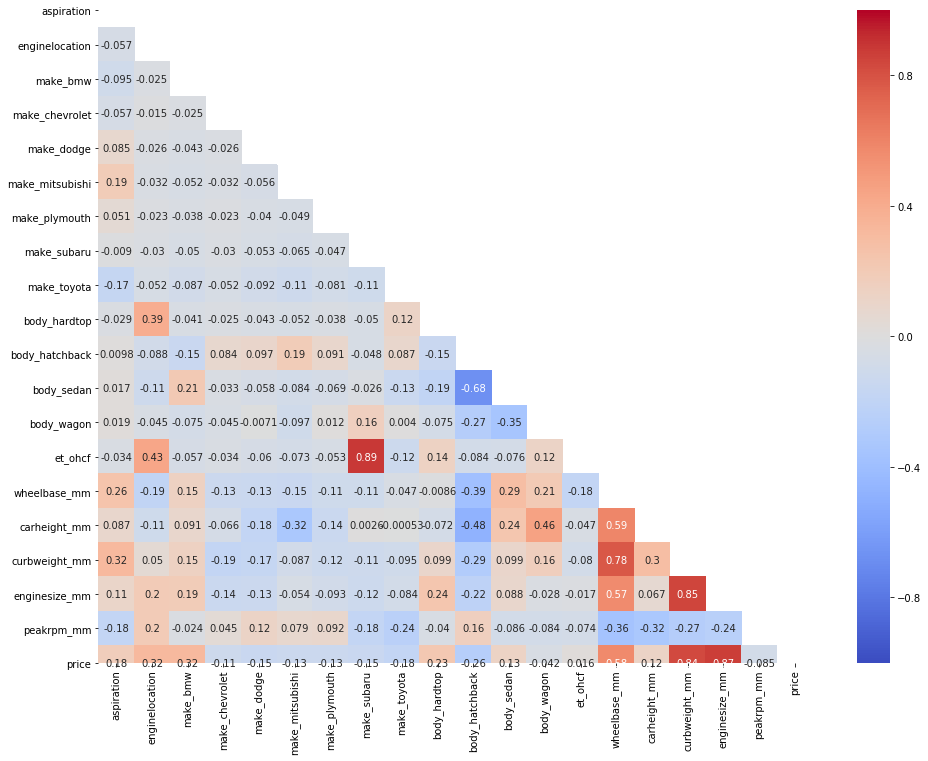

In [110]:
anova_sc2_comparison = pd.concat([X_anova_sc2,y_anova],axis=1)
heat_matrix(anova_sc2_comparison)

In [120]:
# Going to drop 'et_ohcf'
# Going to engineer a new feature 'car_dimensions'
X_anova_sc2.drop(columns=['et_ohcf'],axis=1,inplace=True)
car_dimensions = (X_anova_sc2['curbweight_mm']+X_anova_sc2['enginesize_mm']+
                  X_anova_sc2['carheight_mm']+X_anova_sc2['wheelbase_mm'])/4

In [121]:
# Now to drop those columns
X_anova_sc2.drop(columns=['curbweight_mm','enginesize_mm','carheight_mm','wheelbase_mm'],axis=1,inplace=True)

In [122]:
# Replace with 'car_dimensions'
X_anova_sc2['car_dimensions'] = car_dimensions

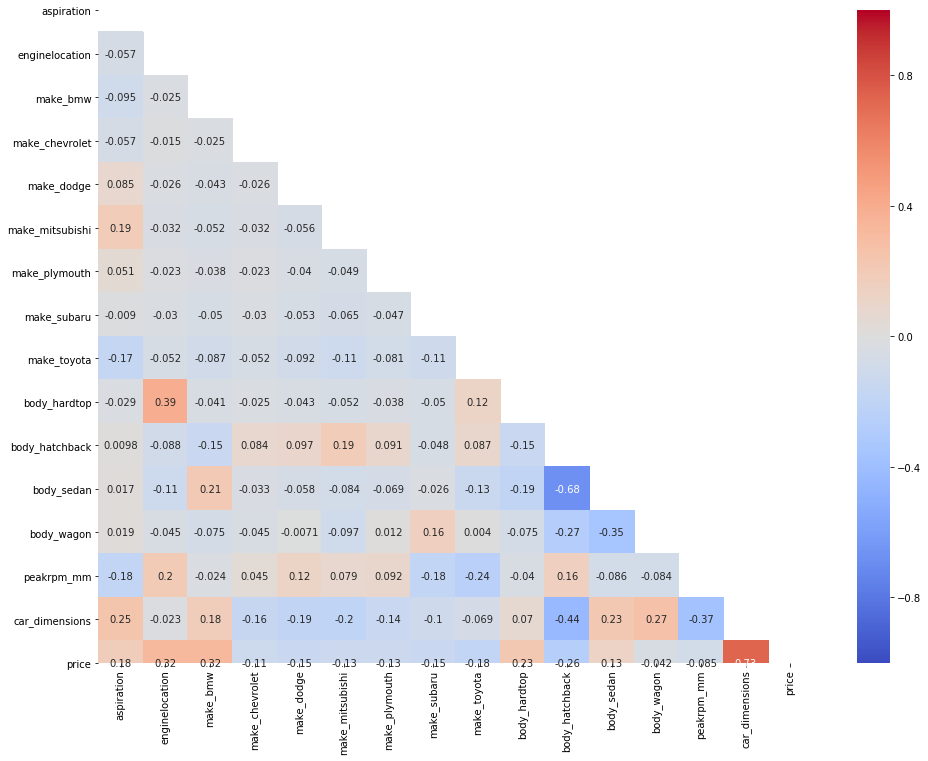

In [123]:
# Run the heat matrix again
anova_sc2_comparison = pd.concat([X_anova_sc2,y_anova],axis=1)
heat_matrix(anova_sc2_comparison)

Much better. Time to remodel.

New R^2 value for training data is:  0.7961863353084174
Test RMSE:  3947.657130588035


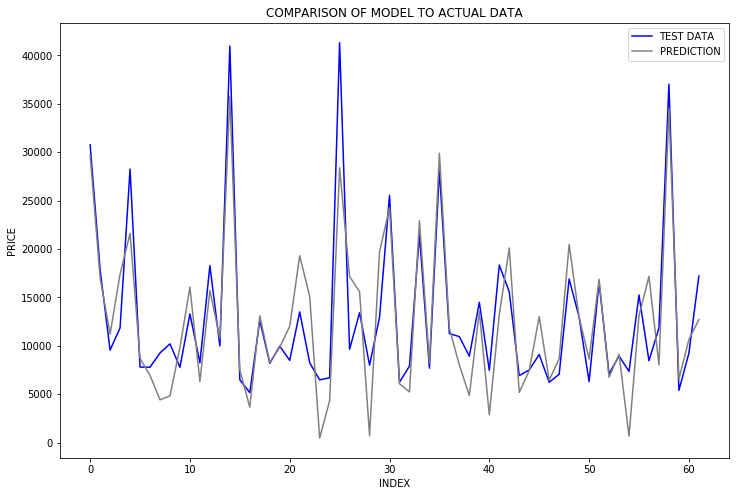

In [124]:
linreg(X_anova_sc2,y_anova)

It seems that my engineered feature decreased model performance.  
  
Going to run some cross_validation techniques, then enter into regularization.  
  
Going to run a cross_val on copy, X_anova, X_rfe, X_anova_sc, X_anova_sc2


In [126]:
from sklearn.model_selection import cross_validate
# Going to create dictionaries for each data set

In [135]:
original = cross_validate(lr, copy.drop(columns=['price'],axis=1), copy.price, cv=3,
              scoring=('r2','neg_mean_squared_error'), return_train_score=True)

In [136]:
anova = cross_validate(lr, X_anova, y_anova, cv=3,
              scoring=('r2','neg_mean_squared_error'), return_train_score=True)

In [137]:
rfe = cross_validate(lr,X_rfe,y_rfe,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [138]:
anova_sc = cross_validate(lr,X_anova_sc,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [139]:
anova_sc2 = cross_validate(lr,X_anova_sc2,y_anova,cv=3,scoring=('r2','neg_mean_squared_error'),
               return_train_score=True)

In [141]:
# Saving the TRAIN R2 values into a data frame
train_r2 = pd.DataFrame()
train_r2['original'] = original['train_r2']
train_r2['anova'] = anova['train_r2']
train_r2['rfe'] = rfe['train_r2']
train_r2['anova_sc'] = anova_sc['train_r2']
train_r2['anova_sc2'] = anova_sc2['train_r2']

Text(0, 0.5, 'TRAIN R2 SCORE')

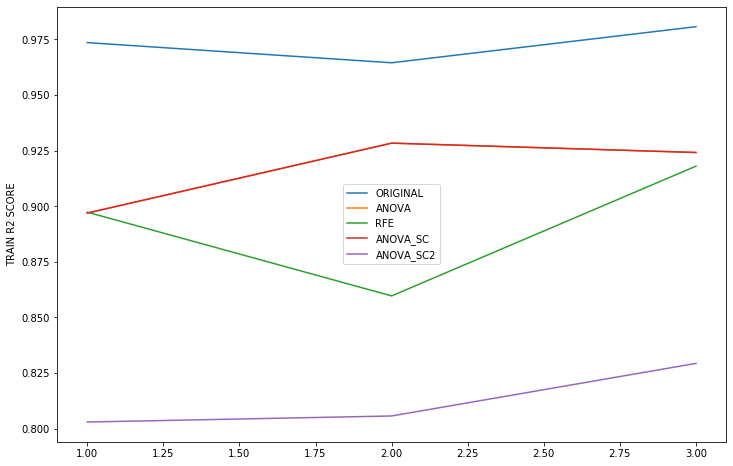

In [154]:
fig,ax=plt.subplots(figsize=(12,8))
sns.lineplot(x=[1,2,3],y=train_r2['original'], ax=ax)
sns.lineplot(x=[1,2,3],y=train_r2['anova'], ax=ax)
sns.lineplot(x=[1,2,3],y=train_r2['rfe'], ax=ax)
sns.lineplot(x=[1,2,3],y=train_r2['anova_sc'], ax=ax)
sns.lineplot(x=[1,2,3],y=train_r2['anova_sc2'], ax=ax)
plt.legend(['ORIGINAL','ANOVA','RFE','ANOVA_SC','ANOVA_SC2'], loc='best')
plt.ylabel('TRAIN R2 SCORE')

In [155]:
# Saving the TEST R2 values into a data frame
test_r2 = pd.DataFrame()
test_r2['original'] = original['test_r2']
test_r2['anova'] = anova['test_r2']
test_r2['rfe'] = rfe['test_r2']
test_r2['anova_sc'] = anova_sc['test_r2']
test_r2['anova_sc2'] = anova_sc2['test_r2']

Text(0, 0.5, 'TEST R2 SCORE')

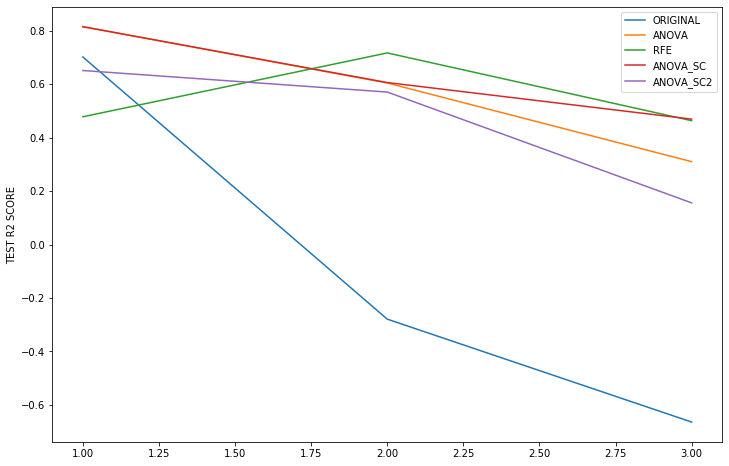

In [158]:
fig,ax=plt.subplots(figsize=(12,8))
sns.lineplot(x=[1,2,3],y=test_r2['original'], markers='.', ax=ax)
sns.lineplot(x=[1,2,3],y=test_r2['anova'], markers='.', ax=ax)
sns.lineplot(x=[1,2,3],y=test_r2['rfe'], markers='.', ax=ax)
sns.lineplot(x=[1,2,3],y=test_r2['anova_sc'], markers='.', ax=ax)
sns.lineplot(x=[1,2,3],y=test_r2['anova_sc2'], markers='.', ax=ax)
plt.legend(['ORIGINAL','ANOVA','RFE','ANOVA_SC','ANOVA_SC2'], loc='best')
plt.ylabel('TEST R2 SCORE')

Seems here that the ANOVA_SC (anova data with scaling) beats the RFE data by a hair at the final cross validation fold. 

----

### Regularization
Going to try out Lasso and Ridge regularization with GridSearchCV

In [163]:
lasso = LassoCV(n_alphas=1000,cv=3,random_state=42)
ridge = RidgeCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                         0.3, 0.6, 1], cv=3)